<a href="https://colab.research.google.com/github/Sarith99/ML_Courses_Practicals/blob/main/Lesson_08_Practical_05_forecasting_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) /period
  return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

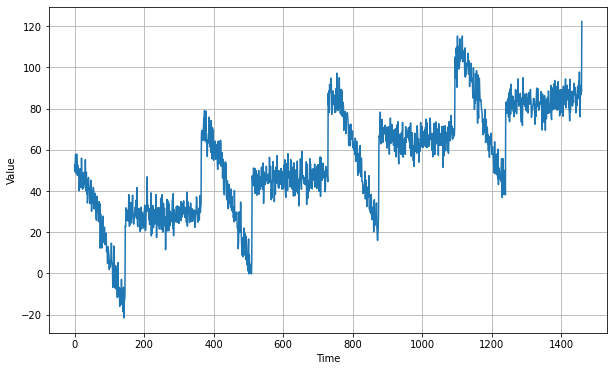

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
split_time = 1000
time_trains = time[:split_time]
x_trains = series[:split_time]
time_val = time[split_time:]
x_val = time[split_time:]

## Linear Model

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_trains, window_size)
valid_set = window_dataset(x_val, window_size)

model = keras.models.Sequential([
                  keras.layers.Dense(1, input_shape=[window_size])              
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
model.fit(train_set, epochs =100, validation_data = valid_set)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 3s 49ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 331.7043 - val_mae: 332.2043
Epoch 2/100
31/31 [==============================] - 1s 14ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 72.1088 - val_mae: 72.6088
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 13.6262 - val_mae: 14.1262
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 24.2494 - val_mae: 24.7494
Epoch 5/100
31/31 [==============================] - 1s 11ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 1.7746 - val_mae: 2.2746
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 75.5088 - val_mae: 76.0088
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 28.4494 - val_mae: 28.9494
Epoch 8/100
31/31 [==============================] -

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_trains, window_size)

model = keras.models.Sequential([
                                 keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch/30)
)
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 4ms/step - loss: 67.6867 - mae: 68.1863 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 52.3572 - mae: 52.8561 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 17.6521 - mae: 18.1484 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 8.4604 - mae: 8.9488 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9765 - mae: 8.4627 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 7.9201 - mae: 8.4035 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 1s 7ms/step - loss: 7.8785 - mae: 8.3609 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 7.8191 - mae: 8.3014 - lr: 1.8478e-06
Epoch

(1e-06, 0.001, 0.0, 20.0)

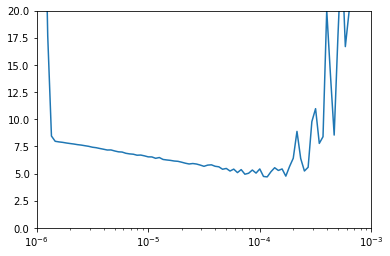

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_trains, window_size)
valid_set = window_dataset(x_val, window_size)

dModel = keras.models.Sequential([
                                  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer= keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 2s 22ms/step - loss: 11.6128 - mae: 12.1050 - val_loss: 155.6924 - val_mae: 156.1924
Epoch 2/500
31/31 [==============================] - 1s 9ms/step - loss: 6.2959 - mae: 6.7765 - val_loss: 44.2356 - val_mae: 44.7356
Epoch 3/500
31/31 [==============================] - 1s 10ms/step - loss: 6.1262 - mae: 6.6108 - val_loss: 19.6818 - val_mae: 20.1818
Epoch 4/500
31/31 [==============================] - 1s 13ms/step - loss: 5.9937 - mae: 6.4784 - val_loss: 32.7100 - val_mae: 33.2100
Epoch 5/500
31/31 [==============================] - 1s 9ms/step - loss: 5.9301 - mae: 6.4140 - val_loss: 18.5410 - val_mae: 19.0410
Epoch 6/500
31/31 [==============================] - 1s 12ms/step - loss: 5.8840 - mae: 6.3675 - val_loss: 10.0952 - val_mae: 10.5952
Epoch 7/500
31/31 [==============================] - 1s 16ms/step - loss: 5.8201 - mae: 6.3002 - val_loss: 20.3244 - val_mae: 20.8244
Epoch 8/500
31/31 [==============================] - 1s 14ms/step - loss

In [10]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [14]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [15]:
lin_forecast.shape

(461,)

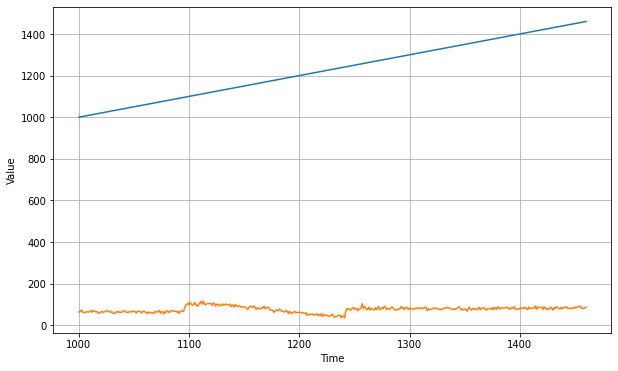

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, lin_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_val, lin_forecast).numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1153.6987>>

## Dense Model Forecasting

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_trains, window_size)

model = keras.models.Sequential([
                                 keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
                                 keras.layers.Dense(10, activation="relu"),
                                 keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10 **(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 2s 8ms/step - loss: 43.8270 - mae: 44.3262 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 1s 7ms/step - loss: 41.5210 - mae: 42.0202 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 1s 7ms/step - loss: 38.6253 - mae: 39.1248 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 1s 6ms/step - loss: 35.3203 - mae: 35.8201 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 31.5905 - mae: 32.0903 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 27.4033 - mae: 27.9022 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 22.7830 - mae: 23.2804 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 17.7632 - mae: 18.2594 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 12.6771 - mae: 13.1682 - lr: 2.5119

(1e-07, 0.005, 0.0, 30.0)

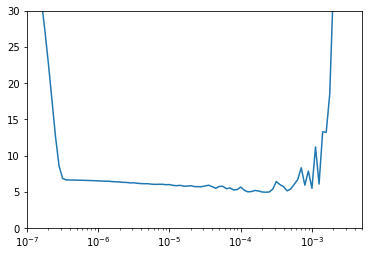

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_trains, window_size)
valid_set = window_dataset(x_val, window_size)

model = keras.models.Sequential([
                                 keras.layers.Dense(10, activation='relu', input_shape= [window_size]),
                                 keras.layers.Dense(10, activation='relu'),
                                 keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr = 1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data = valid_set,
          callbacks=[early_stopping])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 10ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 62.7587 - val_mae: 63.2587
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 44.9418 - val_mae: 45.4418
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 41.3369 - val_mae: 41.8369
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 50.3255 - val_mae: 50.8255
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 14.4895 - val_mae: 14.9895
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 50.6161 - val_mae: 51.1161
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 17.7760 - val_mae: 18.2760
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 6.902

In [23]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

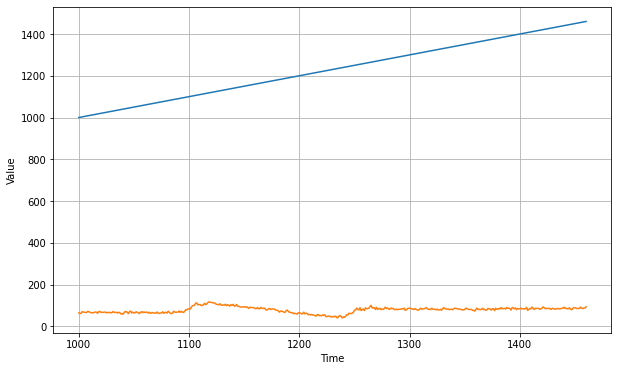

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, dense_forecast)

In [26]:
keras.metrics.mean_absolute_error(x_val, dense_forecast).numpy()

1151.79